nb_header_exercises_solutions.drawio.svg

# Part III: Forecasting

For the following time series:
- The supplementary data in https://www.sciencedirect.com/science/article/pii/S0148296323004617#da1
- Bikes renting: select the start date as index and only one bike stop: https://www.kaggle.com/datasets/kalacheva/london-bike-share-usage-dataset
- Madrid air quality for the Vallecas station (use the data you preprocessed in 02): 'https://datos.madrid.es/egob/catalogo/201200-10306320-calidad-aire-horario.zip'

1) Preprocess the data

2) Make a basic EDA

3) Test 2-3 methods of the guided lesson notebook (selection is up to you)

4) Check the errors metric. Which was the best option? Did the time series got an specific trend? Was it stationary?

## Solución de ejemplo usando el dataset de las bicis

 Importamos el dataset usando las instrucciones de Kaggle, bastante menos lioso que con el json.

In [78]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kalacheva/london-bike-share-usage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/kalacheva/london-bike-share-usage-dataset/versions/1


In [79]:
! ls {path}

LondonBikeJourneyAug2023.csv


In [80]:
import pandas as pd

In [81]:
path = "/root/.cache/kagglehub/datasets/kalacheva/london-bike-share-usage-dataset/versions/1"
df = pd.read_csv(path+"/LondonBikeJourneyAug2023.csv")

In [82]:
df.head()

,Number,Start date,Start station number,Start station,End date,End station number,End station,Bike number,Bike model,Total duration,Total duration (ms)
0,132825189,8/1/2023 0:00,1190,"Kennington Lane Rail Bridge, Vauxhall",8/1/2023 0:17,1059,"Albert Embankment, Vauxhall",23715,CLASSIC,16m 46s,1006663
1,132825190,8/1/2023 0:00,1190,"Kennington Lane Rail Bridge, Vauxhall",8/1/2023 0:17,1059,"Albert Embankment, Vauxhall",41267,CLASSIC,16m 47s,1007128
2,132825191,8/1/2023 0:00,983,"Euston Road, Euston",8/1/2023 0:11,3500,"Baldwin Street, St. Luke's",53180,CLASSIC,11m 6s,666395
3,132825192,8/1/2023 0:01,3479,"Old Brompton Road, South Kensington",8/1/2023 0:12,1140,"Grosvenor Road, Pimlico",53431,CLASSIC,11m 53s,713059
4,132825193,8/1/2023 0:01,1219,"Lower Marsh, Waterloo",8/1/2023 0:17,200056,"Vauxhall Walk, Vauxhall",54758,CLASSIC,16m 3s,963786


In [83]:
df = df [[ 'Start date', 'Start station number', 'Total duration (ms)']]

In [84]:
df.head()

,Start date,Start station number,Total duration (ms)
0,8/1/2023 0:00,1190,1006663
1,8/1/2023 0:00,1190,1007128
2,8/1/2023 0:00,983,666395
3,8/1/2023 0:01,3479,713059
4,8/1/2023 0:01,1219,963786


In [85]:
df.shape

(776527, 3)

In [86]:
df = df [ df['Start station number'] == 1190]

In [87]:
df.shape

(1799, 3)

In [88]:
df.columns

Index(['Start date', 'Start station number', 'Total duration (ms)'], dtype='object')

In [89]:
df = df [['Start date', 'Total duration (ms)']]

In [90]:
df.head()

,Start date,Total duration (ms)
0,8/1/2023 0:00,1006663
1,8/1/2023 0:00,1007128
210,8/1/2023 1:16,1181116
255,8/1/2023 1:42,636427
390,8/1/2023 3:53,348706


In [91]:
df.index = pd.to_datetime(df['Start date'], utc=True)

In [92]:
df = df [[ 'Total duration (ms)']]

La tabla final, con el índice traducido a tiempo y filtrando quedaría tal que así:

In [93]:
print(df.shape)
df.head()

(1799, 1)


,Total duration (ms)
Start date,
2023-08-01 00:00:00+00:00,1006663
2023-08-01 00:00:00+00:00,1007128
2023-08-01 01:16:00+00:00,1181116
2023-08-01 01:42:00+00:00,636427
2023-08-01 03:53:00+00:00,348706


Si queremos facilitarnos el trabajo después, podemos renombrar la variable. Quedaría así:

In [94]:
df.index.name = 'Date'

In [95]:
df.rename(columns={'Total duration (ms)': 'value'}, inplace=True)

In [96]:
df.head()

,value
Date,
2023-08-01 00:00:00+00:00,1006663
2023-08-01 00:00:00+00:00,1007128
2023-08-01 01:16:00+00:00,1181116
2023-08-01 01:42:00+00:00,636427
2023-08-01 03:53:00+00:00,348706


### Comprobar nulos + evenly spaced

In [97]:
# Check for missing values
df.isnull().sum()

,0
value,0


No hay nulos => ¡Mejor! No hará falta rellenar. Si no, hubieramos probado 2-3 técnicas como en 02 y elegido la mejor. Si usamos una máscara y vemos la gráfica, podemos hacernos una idea de cuál es la mejor. [Ver 02]

## Dividir en train / test

In [98]:
# Define the train-test split ratio
train_ratio = 0.8

# Calculate the index to split the time series
split_index = int(len(df) * train_ratio)

# Split the time series into train and test sets
train_df = df[:split_index]
test_df = df[split_index:]


## Probar 2-3 técnicas y comprobar con MSE cuál "sale ganando"

### Con persistencia

In [99]:
import numpy as np

In [100]:
forecast_horizon = 20
values = train_df.values

forecast_time = test_df.index
forecast_values = test_df.values.copy()
for t in range(len(forecast_time)):
  val = t-forecast_horizon+len(train_df)+1
  #print(f"Checking {val} | {len(train_df)}")
  if val > len(train_df)-2:
    #print("Using predictions")
    val = val - len(train_df)+1
    #print(f"New val = {val}")
    forecast_values[t] = forecast_values[val]
  else:
    #print("Using known dataset")
    forecast_values[t] = train_df.values[val]

In [101]:
#! pip install tslearn

In [102]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tslearn.metrics import dtw
import matplotlib.pyplot as plt

In [105]:
def plot_and_validate(train, test, predictions):
    errors = pd.DataFrame(columns=['Feature', 'RMSE', 'RMSE %', 'MAE', 'MAE %', 'DTW', 'DTW %'])

    if len(test.columns) > 1:
        test_values = test.values
        for i, column in enumerate(test.columns):
            value_range = np.max(test[column]) - np.min(test[column])
            rmse = np.sqrt(mean_squared_error(test[column], predictions[:, i]))
            rmse_pcnt = rmse / value_range * 100
            mae = mean_absolute_error(test[column], predictions[:, i])
            mae_pcnt = mae / value_range * 100
            dtw_ = dtw(test[column].values.flatten(), predictions[:, i].flatten())
            dtw_pcnt = dtw_ / value_range * 100

            new_row = pd.DataFrame({'Feature': [column], 'RMSE': [rmse], 'RMSE %': [rmse_pcnt],
                                    'MAE': [mae], 'MAE %': [mae_pcnt], 'DTW': [dtw_], 'DTW %': [dtw_pcnt]})
            if i == 0:
                errors = new_row
            else:
                errors = pd.concat([errors, new_row], ignore_index=True)
    else:
        test_values = test.iloc[:, 0].values.flatten()
        predictions = np.array(predictions).flatten()
        value_range = np.max(test_values) - np.min(test_values)
        rmse = np.sqrt(mean_squared_error(test_values, predictions))
        rmse_pcnt = rmse * 100 / value_range
        mae = mean_absolute_error(test_values, predictions)
        mae_pcnt = mae * 100 / value_range
        dtw_ = dtw(test_values, predictions)
        dtw_pcnt = dtw_ * 100 / value_range

        new_row = pd.DataFrame({'Feature': ['Value'], 'RMSE': [rmse], 'RMSE %': [rmse_pcnt],
                                'MAE': [mae], 'MAE %': [mae_pcnt], 'DTW': [dtw_], 'DTW %': [dtw_pcnt]})
        errors = new_row

    # Graficar
    plt.figure(figsize=(18, 6))

    # Graficar train set con su índice de tiempo
    plt.plot(train.index, train.values, label='Train Set')

    # Graficar test set con su índice de tiempo
    test_x = test.index
    plt.plot(test_x, test_values, label='Test Set')

    # Graficar predicciones con el mismo índice que test
    plt.plot(test_x, predictions, label='Predictions')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Predictions vs Ground Truth')
    plt.legend()
    plt.xticks(rotation=45)  # Rotar etiquetas si son fechas
    plt.show()

    return errors, plt


Test RMSE: 946913.761


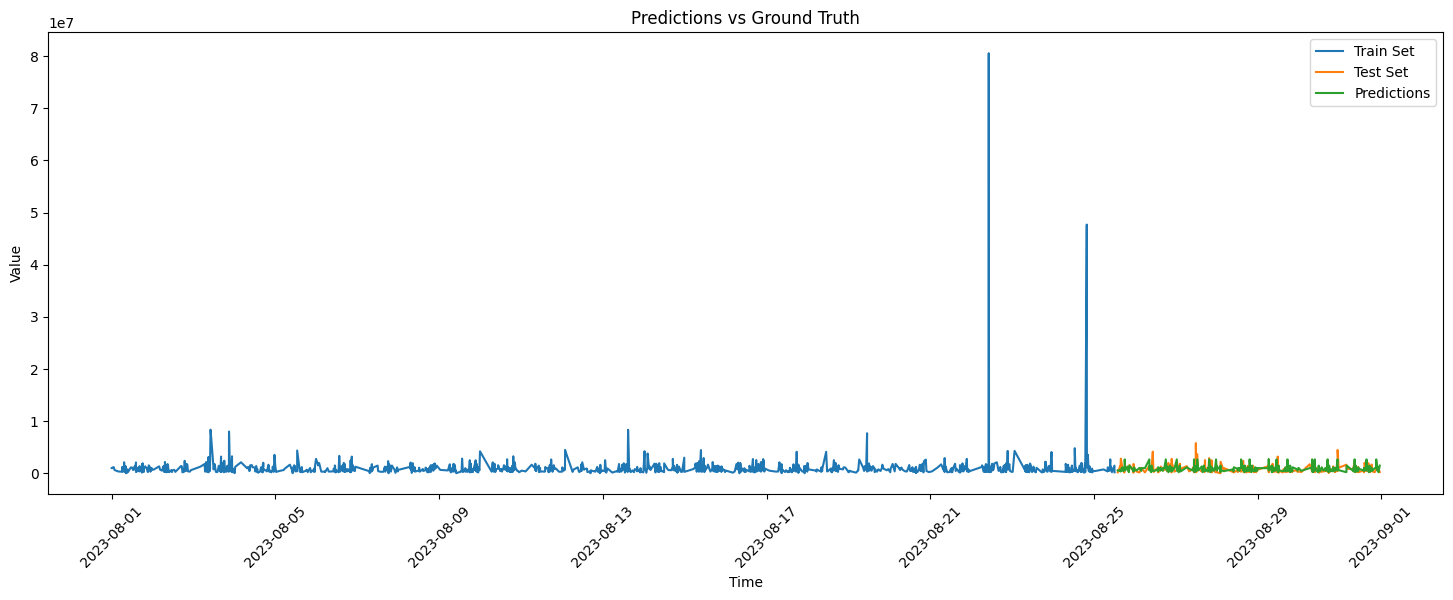

,Feature,RMSE,RMSE %,MAE,MAE %,DTW,DTW %
0,Value,946913.760641,16.402126,642601.105556,11.130923,9.056060e+06,156.866062


In [106]:
rmse = np.sqrt(mean_squared_error(test_df.values, forecast_values))
print('Test RMSE: %.3f' % rmse)

# Plot train set
errors, plot = plot_and_validate(train_df, test_df, forecast_values)
display(errors)